## Import packages

In [1]:
import sys
!{sys.executable} -m pip install pokebase

import pokebase as pb 
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import json
import pandas as pd
import math
import matplotlib.pyplot as plt

# Part 1: Data Collection and Cleaning

## Obtain list of legendary and mystical Pokémon from Bulbapedia

In [2]:
# scrape list of legendary and mystical pokemon from bulbapedia
page = requests.get("https://bulbapedia.bulbagarden.net/wiki/Legendary_Pok%C3%A9mon")
soup = BeautifulSoup(page.content, 'html.parser')

# list of <a> tags of legendary pokemon
a_list = soup.select('td[style*="background: #e6e6ff"] a')

# extract text from <a> tags
legend_list = [lp.get_text() for lp in a_list]

# data cleaning: replace whitespace with hyphen, remove colon
legend_list = [p.lower().replace(' ', '-').replace(':', '') for p in legend_list]
legend_list_smogon = legend_list.copy()
legend_list

['articuno',
 'zapdos',
 'moltres',
 'mewtwo',
 'mew',
 'raikou',
 'entei',
 'suicune',
 'lugia',
 'ho-oh',
 'celebi',
 'regirock',
 'regice',
 'registeel',
 'latias',
 'latios',
 'kyogre',
 'groudon',
 'rayquaza',
 'jirachi',
 'deoxys',
 'uxie',
 'mesprit',
 'azelf',
 'dialga',
 'palkia',
 'heatran',
 'regigigas',
 'giratina',
 'cresselia',
 'phione',
 'manaphy',
 'darkrai',
 'shaymin',
 'arceus',
 'victini',
 'cobalion',
 'terrakion',
 'virizion',
 'tornadus',
 'thundurus',
 'reshiram',
 'zekrom',
 'landorus',
 'kyurem',
 'keldeo',
 'meloetta',
 'genesect',
 'xerneas',
 'yveltal',
 'zygarde',
 'diancie',
 'hoopa',
 'volcanion',
 'type-null',
 'silvally',
 'tapu-koko',
 'tapu-lele',
 'tapu-bulu',
 'tapu-fini',
 'cosmog',
 'cosmoem',
 'solgaleo',
 'lunala',
 'necrozma',
 'magearna',
 'marshadow',
 'zeraora',
 'meltan',
 'melmetal']

## After scraping and cleaning, test for validity by searching for each name in the API

In [3]:
for p in legend_list:
    try:
        pb.pokemon(p)
    except ValueError:
        print("Cannot find", p)

Cannot find deoxys
Cannot find giratina
Cannot find shaymin
Cannot find tornadus
Cannot find thundurus
Cannot find landorus
Cannot find keldeo
Cannot find meloetta
Cannot find meltan
Cannot find melmetal


## The above Pokémon have alternate forms and we must handle each manually

P.S. Meltan and Melmetal haven't been added to the database at the moment. https://github.com/PokeAPI/pokeapi/issues/414

In [4]:
# deoxys: deoxys-normal, deoxys-attack, deoxys-defense, deoxys-speed
try:
    legend_list.remove('deoxys')
    legend_list.extend(['deoxys-normal', 'deoxys-attack', 'deoxys-defense', 'deoxys-speed'])
except ValueError:
    print('Error')

# giratina: giratina-altered, giratina-origin
try:
    legend_list.remove('giratina')
    legend_list.extend(['giratina-altered', 'giratina-origin'])
except ValueError:
    print('Error')

# shaymin: shaymin-land, shaymin-sky
try:
    legend_list.remove('shaymin')
    legend_list.extend(['shaymin-land', 'shaymin-sky'])
except ValueError:
    print('Error')

# tornadus: tornadus-incarnate, tornadus-therian
try:
    legend_list.remove('tornadus')
    legend_list.extend(['tornadus-incarnate', 'tornadus-therian'])
except ValueError:
    print('Error')

# thundurus: thundurus-incarnate, thundurus-therian
try:
    legend_list.remove('thundurus')
    legend_list.extend(['thundurus-incarnate', 'thundurus-therian'])
except ValueError:
    print('Error')

# landorus: landorus-incarnate, landorus-therian
try:
    legend_list.remove('landorus')
    legend_list.extend(['landorus-incarnate', 'landorus-therian'])
except ValueError:
    print('Error')

# keldeo: keldeo-ordinary, keldeo-resolute
try:
    legend_list.remove('keldeo')
    legend_list.extend(['keldeo-ordinary', 'keldeo-resolute'])
except ValueError:
    print('Error')

# meloetta: meloetta-aria, meloetta-pirouette
try:
    legend_list.remove('meloetta')
    legend_list.extend(['meloetta-aria', 'meloetta-pirouette'])
except ValueError:
    print('Error')

# meltan: remove for now
try:
    legend_list.remove('meltan')
except ValueError:
    print('Error')

# melmetal: remove for now
try:
    legend_list.remove('melmetal')
except ValueError:
    print('Error')

## Test again for validity

In [5]:
for p in legend_list:
    try:
        pb.pokemon(p)
    except ValueError:
        print("Cannot find", p)

## Get CSV file for all Pokémon info

In [6]:
# #Only run if you need the DF in the code itself, the cell above should retrieve the file
# import re
# pokemonList = []
# pokemonList.append(['ID', 'Pokemon', 'Legendary', 'Stat Total', 'ATK Sum', 'DEF Sum', 'Height', 'Weight', 'Type 1', 'Type 2'])

# for pokemonID in range(1,808):
#   pokemon_stats = []
#   pokemon_info = pb.pokemon(pokemonID)
  
#   pokemon_stats.append(pokemonID) # Add ID
#   pokemon_stats.append(pokemon_info.name) # Add Name
#   pokemon_stats.append(pokemon_info.name in legend_list) # Add Legendary or Not
#   pokemon_stats.extend([0,0,0]) # Add categories for stat totals
#   pokemon_stats.append(pokemon_info.height) # Add Height
#   pokemon_stats.append(pokemon_info.weight) # Add Weight

#   print(pokemonID)
#   j = 0 # Counter because I didnt want to change my code anymore
#   for i in (pokemon_info.stats):
#     stringStats = str(i)
#     value = [int(s) for s in re.findall(r'\b\d+\b', stringStats)[:1]]
#     pokemon_stats[3] += value[0]
#     pokemon_stats[4+(j%2)] += value[0]
#     j += 1
   
#   for i in pokemon_info.types:
#     stringType = str(i)
#     typing = re.findall('\'name\': \'(.+?)\'', stringType)
#     pokemon_stats.append(typing[0])
    
    
#   if len(pokemon_info.types) == 1:
#     pokemon_stats.append("N/A")
    
#   pokemonList.append(pokemon_stats)

# statsDF = pd.DataFrame(pokemonList[1:], columns=pokemonList[0])
# statsDF.to_csv ('./statsDF.csv', index = None, header=True)

# statsDF

In [7]:
df = pd.read_csv('statsDF.csv')
df

,ID,Pokemon,Legendary,Stat Total,ATK Sum,DEF Sum,Height,Weight,Type 1,Type 2
0,1,bulbasaur,False,318,159,159,7,69,poison,grass
1,2,ivysaur,False,405,202,203,10,130,poison,grass
2,3,venusaur,False,525,262,263,20,1000,poison,grass
3,4,charmander,False,309,177,132,6,85,fire,NaN
4,5,charmeleon,False,405,224,181,11,190,fire,NaN
5,6,charizard,False,534,293,241,17,905,flying,fire
6,7,squirtle,False,314,141,173,5,90,water,NaN
7,8,wartortle,False,405,186,219,10,225,water,NaN
8,9,blastoise,False,530,246,284,16,855,water,NaN
9,10,caterpie,False,195,95,100,3,29,bug,NaN


## Obtain list of Pokémon types

In [8]:
# scrape list of pokemon types from bulbapedia
page = requests.get("https://bulbapedia.bulbagarden.net/wiki/Type")
soup = BeautifulSoup(page.content, 'html.parser')

# list of <a> tags of types
a_list = soup.select('td a[title*="(type)"]')

# extract text from <a> tags
type_list = [lp.get_text() for lp in a_list]

# ignore ??? type
type_list = type_list[:-1]
type_list

['Normal',
 'Fire',
 'Fighting',
 'Water',
 'Flying',
 'Grass',
 'Poison',
 'Electric',
 'Ground',
 'Psychic',
 'Rock',
 'Ice',
 'Bug',
 'Dragon',
 'Ghost',
 'Dark',
 'Steel',
 'Fairy']

## Fetch txt file from Smogon

In [9]:
data = urlopen("https://www.smogon.com/stats/2019-03/gen7ubers-0.txt")
usage = []
for line in data:
    decoded = line.decode('utf-8')
    decoded = decoded.replace(" ", "")
    if decoded.startswith('|'):
        # usage - weighted based on matchmaking rating
        # raw - unweighted usage (on team)
        # real - actually used in battle
        decodedList = decoded.split('|')[1:-1]
        decodedList.pop(2) # remove usage %
        decodedList.pop() # remove real
        decodedList.pop() # remove real %
        usage.append(decodedList)

# real - actually used in battle
# raw - unweighted usage (on team)
# usage - weighted based on matchmaking rating
smogon_df = pd.DataFrame(usage[1:], columns=usage[0])
smogon_df

,Rank,Pokemon,Raw,%
0,1,Groudon-Primal,274400,39.068%
1,2,Xerneas,198831,28.309%
2,3,Necrozma-Dusk-Mane,149044,21.220%
3,4,Yveltal,147205,20.959%
4,5,Kyogre-Primal,145560,20.724%
5,6,Marshadow,144160,20.525%
6,7,Arceus,85301,12.145%
7,8,Zygarde,71765,10.218%
8,9,Lugia,69956,9.960%
9,10,Aegislash,68805,9.796%


## Match legendary list to Smogon names

In [10]:
legend_list_smogon.extend(['deoxys-attack', 'deoxys-defense', 'deoxys-speed'])
legend_list_smogon.extend(['giratina-origin'])
legend_list_smogon.extend(['shaymin-sky'])
legend_list_smogon.extend(['tornadus-therian'])
legend_list_smogon.extend(['thundurus-therian'])
legend_list_smogon.extend(['landorus-therian'])

try:
    legend_list_smogon.remove('meltan')
except ValueError:
    print('Error')

try:
    legend_list_smogon.remove('melmetal')
except ValueError:
    print('Error')

# smogon pokemon names are captialized
legend_list_smogon = [str.title(name) for name in legend_list_smogon]

try:
    legend_list_smogon.remove('Tapu-Koko')
    legend_list_smogon.extend(['TapuKoko'])
except ValueError:
    print('Error')

try:
    legend_list_smogon.remove('Tapu-Lele')
    legend_list_smogon.extend(['TapuLele'])
except ValueError:
    print('Error')

try:
    legend_list_smogon.remove('Tapu-Bulu')
    legend_list_smogon.extend(['TapuBulu'])
except ValueError:
    print('Error')

try:
    legend_list_smogon.remove('Tapu-Fini')
    legend_list_smogon.extend(['TapuFini'])
except ValueError:
    print('Error')

try:
    legend_list_smogon.remove('Type-Null')
    legend_list_smogon.extend(['Type:Null'])
except ValueError:
    print('Error')

# Part 2: Smogon Competitive Usage Data Analysis

## Use pandas to visualize Smogon competitive usage data

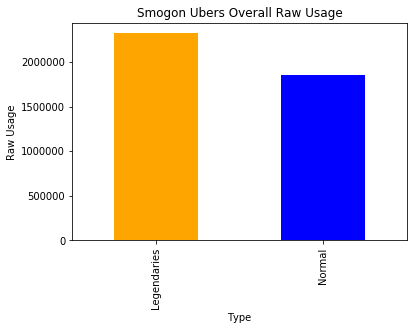

In [11]:
# print(len(legend_list_smogon)) = 76

# convert string to floats
smogon_df['Raw'] = smogon_df['Raw'].astype(int)

# using legend_list_smogon, split dataframe
smogon_legend_df = smogon_df[smogon_df['Pokemon'].str.contains('|'.join(legend_list_smogon))].copy()
smogon_legend_df['Rank'] = smogon_legend_df['Rank'].astype(int)
smogon_normal_df = smogon_df[-smogon_df['Pokemon'].str.contains('|'.join(legend_list_smogon))].copy()
smogon_normal_df['Rank'] = smogon_normal_df['Rank'].astype(int)

# plot raw usage of legendaries vs normal
smogon_usage_graph_data = [
  ['Legendaries', smogon_legend_df['Raw'].sum()],
  ['Normal', smogon_normal_df['Raw'].sum()]
]
smogon_usage_graph_df = pd.DataFrame(smogon_usage_graph_data, columns = ['Type', 'Raw Usage'])
ax_smogon_usage = smogon_usage_graph_df.plot.bar(x = 'Type', y = 'Raw Usage', title = 'Smogon Ubers Overall Raw Usage',
  legend = False, color = ['orange', 'blue'])
ax_smogon_usage.set_xlabel('Type')
ax_smogon_usage.set_ylabel('Raw Usage')
plt.show()

TODO: Talk about overall usage (legendaries > normal)

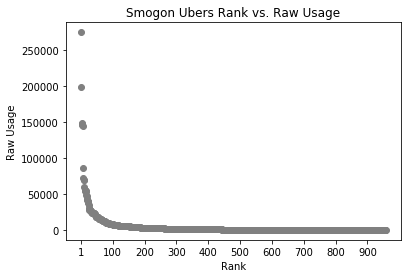

In [12]:
# plot raw usage against rank
plt.scatter(smogon_df['Rank'], smogon_df['Raw'], color = 'gray')
plt.title('Smogon Ubers Rank vs. Raw Usage')
plt.xlabel('Rank')
plt.ylabel('Raw Usage')
plt.xticks([0, *range(99, len(smogon_df), 100)])
plt.show()

TODO: talk about exponential, and the reason for looking at top x%

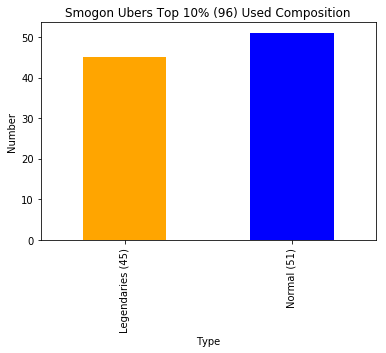

In [13]:
# get the makeup of the top x% used
smogon_top_count = math.ceil(len(smogon_df) * 0.1) # used for the cutoffs
smogon_num_legend = (smogon_legend_df[smogon_legend_df['Rank'] <= smogon_top_count])['Rank'].size
smogon_num_normal = (smogon_normal_df[smogon_normal_df['Rank'] <= smogon_top_count])['Rank'].size
smogon_num_graph_data = [
  ['Legendaries ({})'.format(smogon_num_legend), smogon_num_legend],
  ['Normal ({})'.format(smogon_num_normal), smogon_num_normal]
]
smogon_num_graph_df = pd.DataFrame(smogon_num_graph_data, columns = ['Type', 'Count'])
ax_smogon_num = smogon_num_graph_df.plot.bar(x = 'Type', y = 'Count', title = 'Smogon Ubers Top 10% ({}) Used Composition'.format(smogon_top_count),
  legend = False, color = ['orange', 'blue'])
ax_smogon_num.set_xlabel('Type')
ax_smogon_num.set_ylabel('Number')
plt.show()

TODO: talk about top x% results (normal > legendary)

# Part 3: Physical Attributes Analysis

## 3.1 Weight vs. Height

Using a scatter plots, we can examine the relationship between the height and weight of all Pokémon. The plots below show how most Pokémon's measurements concentrate toward the bottom left corner, whereas there are only a few outliers.

### Non-legendaries

[Text(0, 0.5, 'Height (decimetres)'), Text(0.5, 0, 'Weight (hectograms)')]

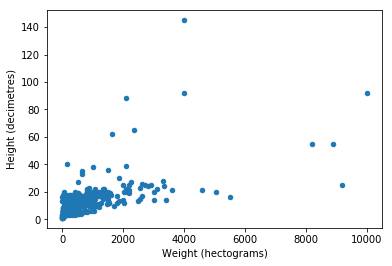

In [14]:
df[~df['Pokemon'].isin(legend_list)][['Height', 'Weight']].plot.scatter('Weight', 'Height').set(xlabel='Weight (hectograms)', ylabel='Height (decimetres)')

### Legendaries

[Text(0, 0.5, 'Height (decimetres)'), Text(0.5, 0, 'Weight (hectograms)')]

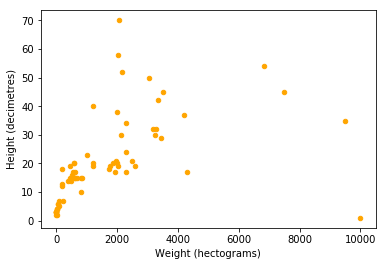

In [15]:
df[df['Pokemon'].isin(legend_list)][['Height', 'Weight']].plot.scatter('Weight', 'Height', c='orange').set(xlabel='Weight (hectograms)', ylabel='Height (decimetres)')

### Combined

[Text(0, 0.5, 'Height (decimetres)'), Text(0.5, 0, 'Weight (hectograms)')]

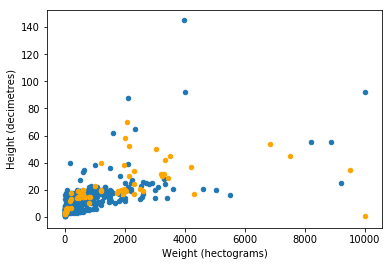

In [16]:
ax = df[~df['Pokemon'].isin(legend_list)][['Height', 'Weight']].plot('Weight', 'Height', kind='scatter')
df[df['Pokemon'].isin(legend_list)][['Height', 'Weight']].plot('Weight', 'Height', kind='scatter', c='orange', ax=ax).set(xlabel='Weight (hectograms)', ylabel='Height (decimetres)')

### Means of Weight and Height

Legendary mean: maroon  
Regular mean: cyan

Legendary Pokemon average weight:  1716.66 ; average height:  20.66
Regular Pokemon average weight:  516.59 ; average height:  10.79


[Text(0, 0.5, 'Height (decimetres)'), Text(0.5, 0, 'Weight (hectograms)')]

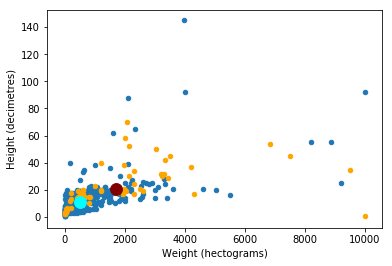

In [17]:
# legendary average height
l_h_mean = df[df['Pokemon'].isin(legend_list)]['Height'].mean()

# legendary average weight
l_w_mean = df[df['Pokemon'].isin(legend_list)]['Weight'].mean()

# regular average height
r_h_mean = df[~df['Pokemon'].isin(legend_list)]['Height'].mean()

# regular avaerage weight
r_w_mean = df[~df['Pokemon'].isin(legend_list)]['Weight'].mean()

# calculate means
df_l_mean = pd.DataFrame({"Weight":[l_w_mean], "Height":[l_h_mean]})
df_r_mean = pd.DataFrame({"Weight":[r_w_mean], "Height":[r_h_mean]})
print('Legendary Pokemon average weight: ', round(df_l_mean.loc[0]['Weight'], 2), '; average height: ', round(df_l_mean.loc[0]['Height'], 2))
print('Regular Pokemon average weight: ', round(df_r_mean.loc[0]['Weight'], 2), '; average height: ', round(df_r_mean.loc[0]['Height'], 2))

# plot
ax = df[~df['Pokemon'].isin(legend_list)][['Height', 'Weight']].plot('Weight', 'Height', kind='scatter')
df[df['Pokemon'].isin(legend_list)][['Height', 'Weight']].plot('Weight', 'Height', kind='scatter', c='orange', ax=ax)
df_l_mean.plot.scatter('Weight', 'Height', c="maroon", s=140, ax = ax)
df_r_mean.plot.scatter('Weight', 'Height', c="cyan", s=140, ax = ax).set(xlabel='Weight (hectograms)', ylabel='Height (decimetres)')


From the plot above, we can conclude that the average legendary Pokémon is likely to be taller and heavier than the average non-legendary Pokémon.

## 3.2 Types

Lets identify what typings legendary Pokemon typically are. First we need to separate the legendary data from the overall dataframe

### Make a list of Pokémon Types

In [18]:
legendsDf = df[df['Pokemon'].isin(legend_list)]

legend_types = list(legendsDf['Type 1']) + list(legendsDf['Type 2'])
types = list(df['Type 1']) + list(df['Type 2'])

legendTypeCount = pd.Series(legend_types).value_counts().append(pd.Series([0],['poison']))
regularTypeCount = pd.Series(types).value_counts()

In [19]:
legendsDf

,ID,Pokemon,Legendary,Stat Total,ATK Sum,DEF Sum,Height,Weight,Type 1,Type 2
143,144,articuno,True,580,265,315,17,554,flying,ice
144,145,zapdos,True,580,315,265,16,526,flying,electric
145,146,moltres,True,580,315,265,20,600,flying,fire
149,150,mewtwo,True,680,394,286,20,1220,psychic,NaN
150,151,mew,True,600,300,300,4,40,psychic,NaN
242,243,raikou,True,580,315,265,19,1780,electric,NaN
243,244,entei,True,580,305,275,21,1980,fire,NaN
244,245,suicune,True,580,250,330,20,1870,water,NaN
248,249,lugia,True,680,290,390,52,2160,flying,psychic
249,250,ho-oh,True,680,330,350,38,1990,flying,fire


Kind of hard to read, so lets just get the counts instead of individual pokemon.

In [23]:
legendTypeCount

psychic     21
flying      10
dragon      10
water        8
steel        8
fire         7
fairy        7
electric     6
fighting     5
normal       5
grass        4
ghost        4
ground       3
ice          3
rock         3
dark         2
bug          1
poison       0
dtype: int64

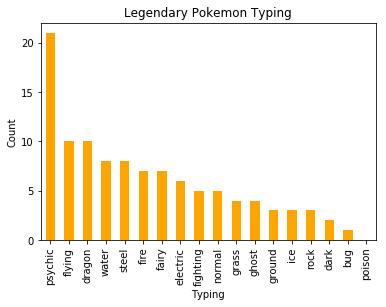

In [20]:
legendPlot = legendTypeCount.plot(kind='bar', title='Legendary Pokemon Typing', yticks=range(0,25,5), color="orange")
xstuff = legendPlot.set_xlabel("Typing")
ystuff = legendPlot.set_ylabel("Count")

Here we can see that psychic dominate the typings for legendary Pokemon, doubling the counts for any other type. From there it slowly declines until we get to poison, where we can see 0 Pokemon have poison typing. Surprisingly, dragon isnt the most frequent typing, which somewhat subverted our expectations but is reasonable once we thought back onto what legendary Pokemon there were.

In [24]:
regularTypeCount

water       131
normal      109
flying       98
grass        97
psychic      82
bug          77
poison       66
fire         64
ground       64
rock         60
fighting     54
electric     48
fairy        47
steel        47
dark         46
dragon       45
ghost        43
ice          34
dtype: int64

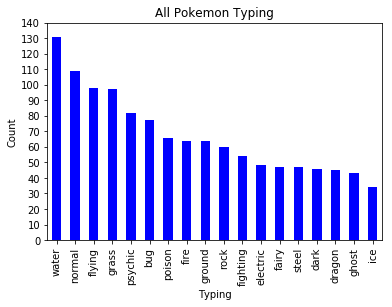

In [21]:
normalPlot = regularTypeCount.plot(kind='bar', title='All Pokemon Typing', yticks=range(0,150,10),  color="blue")
xstuff = normalPlot.set_xlabel("Typing")
ystuff = normalPlot.set_ylabel("Count")

Now with regular pokemon, we can see that its a lot more evenly spread out. Water has a plurality of the typings but is not as dominant as psychic was for legendaries. Poison finds itself near the middle of the type distribution, suggesting that the lack of a legendary Pokemon being poison typed may be intentional rather than through sheer chance. 

In [34]:
typeCompDf = legendTypeCount.to_frame()
typeCompDf = typeCompDf.merge(regularTypeCount.to_frame(), left_index=True, right_index=True)
typeCompDf.columns = ['Legendary','Normal']
typeCompDf=typeCompDf.reindex(columns=['Normal','Legendary'])
normFirst = regularTypeCount.to_frame()
normFirst = normFirst.merge(legendTypeCount.to_frame(), left_index = True, right_index = True)
normFirst.columns = ['Normal','Legendary']




,Normal,Legendary
water,131,8
normal,109,5
flying,98,10
grass,97,4
psychic,82,21
bug,77,1
poison,66,0
fire,64,7
ground,64,3
rock,60,3


Now lets compare the two side-by-side.

In [36]:
typeCompDf

,Normal,Legendary
psychic,82,21
flying,98,10
dragon,45,10
water,131,8
steel,47,8
fire,64,7
fairy,47,7
electric,48,6
fighting,54,5
normal,109,5


In [35]:
normFirst


,Normal,Legendary
water,131,8
normal,109,5
flying,98,10
grass,97,4
psychic,82,21
bug,77,1
poison,66,0
fire,64,7
ground,64,3
rock,60,3


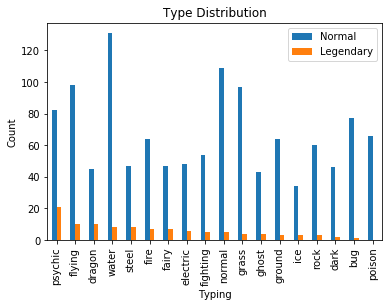

In [37]:
import matplotlib.pyplot as plt
overallPlot = typeCompDf.plot(kind='bar', title ="Type Distribution")
xstuff = overallPlot.set_xlabel("Typing")
ystuff = overallPlot.set_ylabel("Count")

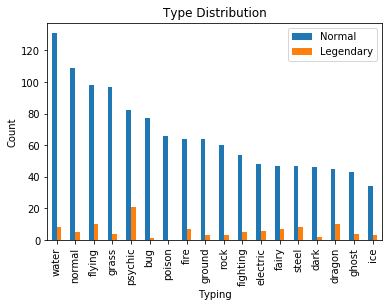

In [38]:
normFirstPlot = normFirst.plot(kind='bar', title ="Type Distribution")
xstuff = normFirstPlot.set_xlabel("Typing")
ystuff = normFirstPlot.set_ylabel("Count")

Through these two graphs, we can see that there only seems to be a small correlation between the typing for all Pokemon in general, and the typing for legendary Pokemon (seen in flying, water, and psychic for both graphs). This suggests that legendary Pokemon are made without this distribution in mind, and more made to appeal to the abstract idea of legendary that most people view as dragons or psychic beings.

# Part 4: Pokémon Stats Analysis